In [1]:
# primary settings
state = 'AL'
district_type = 'CD'
level = 'vtd'
deviation = 0.01  # 0.10 means 10% means +/-5%
minority = 'Black'

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

from read import read_graph_from_json
G = read_graph_from_json( filepath + filename )

# total population
for i in G.nodes:
    G.nodes[i]['TOTPOP'] = G.nodes[i]['P0010001'] 
    
print("number of nodes, edges:",G.number_of_nodes(),G.number_of_edges())

number of nodes, edges: 1837 5221


In [3]:
from number_of_districts import number_of_districts

k = number_of_districts[state, district_type]
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k

import math
L = math.ceil(  ideal_population * (1-deviation/2) )
U = math.floor( ideal_population * (1+deviation/2) )

print("Using k, L, U =",k,L,U)

Using k, L, U = 7 714166 721342


In [4]:
# bidirected version of graph G
import networkx as nx
DG = nx.DiGraph(G)
DG._L = 2 * L
DG._U = 2 * U

In [5]:
# build optimization model to minimize inverse PP score
from district import build_single_district_mip 

m = build_single_district_mip(DG, minority=minority, contiguity='cut', split_counties_limit=2, complement_contiguity='cut')

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-05-11
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter IntFeasTol to value 1e-07


In [6]:
# solve the MISOCP
m.optimize(m._callback)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14192 rows, 12486 columns and 58701 nonzeros
Model fingerprint: 0x59c8b9ae
Model has 1 quadratic constraint
Variable types: 6 continuous, 12480 integer (12480 binary)
Coefficient statistics:
  Matrix range     [3e-05, 3e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+06]
Presolve removed 2 rows and 1 columns
Presolve time: 0.10s
Presolved: 14190 rows, 12485 columns, 58696 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 12482 integer (12480 binary)

Root relaxation: objective 0.000000e+00, 6241 iterations, 0.25 seconds (0.36 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

 51195 45652    4.39952  211   59          -    3.83545      -   145  445s
 52652 46868    4.49339   52   77          -    3.83571      -   143  452s
 53481 47841    4.68086  145   59          -    3.83640      -   142  457s
 54408 48172    4.89271   66   22          -    3.83714      -   142  461s
 54807 48625    4.11761   38   15          -    3.83784      -   142  466s
 55419 49261    4.31138   72   51          -    3.83784      -   142  471s
 56244 49889 infeasible  322               -    3.83796      -   142  475s
 56912 50384    4.14702   24   70          -    3.83928      -   142  480s
H57238 43482                       4.7966316    3.83928  20.0%   142  482s
H57369 25842                       4.2256698    3.83928  9.14%   142  485s
H57626 21707                       4.1789936    3.84312  8.04%   142  487s
H57905 21791                       4.1789936    3.84674  7.95%   142  489s
 58160 21830 infeasible   57         4.17899    3.84966  7.88%   142  492s
H58161 20888             

 89478  3214     cutoff  199         4.10935    4.08984  0.47%   254  995s
 89769  2992     cutoff   45         4.10935    4.09053  0.46%   255 1001s
 90055  2799 infeasible  204         4.10935    4.09129  0.44%   256 1007s
 90393  2607     cutoff   53         4.10935    4.09198  0.42%   257 1020s
H90518  2331                       4.1065437    4.09199  0.35%   257 1020s
 90675  2145 infeasible  112         4.10654    4.09272  0.34%   257 1025s
 90920  1970     cutoff   47         4.10654    4.09347  0.32%   258 1032s
 91120  1800 infeasible   33         4.10654    4.09414  0.30%   259 1038s
 91313  1642     cutoff  141         4.10654    4.09487  0.28%   260 1044s
 91483  1478    4.10173   35   15    4.10654    4.09532  0.27%   261 1051s
 91657  1231     cutoff  251         4.10654    4.09580  0.26%   262 1058s
 91919   985    4.10168   31    8    4.10654    4.09660  0.24%   264 1064s
 92180   736     cutoff   45         4.10654    4.09791  0.21%   264 1070s
 92431   540     cutoff  

In [7]:
print("The inverse Polsby-Popper score is",m.objval)
print("The Polsby-Popper score is",1.0/m.objval)

# retrieve the district and its population
district = [ i for i in G.nodes if m._x[i].x > 0.5 ] 
population = sum( G.nodes[i]["TOTPOP"] for i in district )

print("\nDistrict has this many nodes:",len(district))
print("And a population of:",population)
print("Is it connected?",nx.is_connected(G.subgraph(district)))

The inverse Polsby-Popper score is 4.106543733725234
The Polsby-Popper score is 0.24351378308416413

District has this many nodes: 669
And a population of: 1428403
Is it connected? True


In [8]:
vap = sum( DG.nodes[i]['VAP'] for i in district )
mvap = sum( DG.nodes[i]['MVAP'] for i in district )
print("The total voting age population is:",vap)
print("Among the",minority,"population, the VAP is:",mvap)
print("As a percentage, this is",round( 100 * mvap / vap, 2 ),"%")

The total voting age population is: 1113964
Among the Black population, the VAP is: 556984
As a percentage, this is 50.0 %


In [9]:
# Let's draw the district on a map
from export import draw_single_district
G._state = state
G._level = level

Exporting to png...


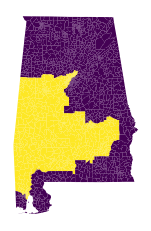

In [10]:
# State-wide view
draw_single_district( G, district, zoom=False )

Exporting to png...


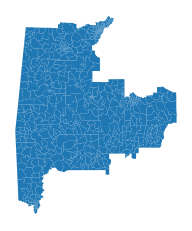

In [11]:
# District-only view
draw_single_district( G, district, zoom=True )